In [231]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

In [232]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [233]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-123.28736502403991,36.53106212747138],
        [-120.57374197716491,36.53106212747138],
        [-120.57374197716491,38.629116592353306],
        [-123.28736502403991,38.629116592353306],
        [-123.28736502403991,36.53106212747138]]])

In [234]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S2_SR = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-07-01', '2018-07-31'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR = image_S2_SR.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 0.3}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR, S2_display, 'Sentinel-S2_SR')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)

In [235]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [236]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S2_SR_sep = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-09-01', '2018-09-30'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR_sep = image_S2_SR_sep.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 3000}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR_sep, S2_display, 'Sentinel-S2_SR_sep')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)


In [237]:
#traing data for July
ground_truth= image_S2_SR.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [238]:
#traing data for September
ground_truth_sep= image_S2_SR_sep.addBands(image_S5P)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [239]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,1355.0,2306.0,1396.0,1134.0,1193.5,933.5,1356.0,2883.5,3306.0,3094.5,3489.0,809.5,0.000093
1,1162.0,1516.0,888.0,924.0,823.0,748.0,991.0,1561.0,1827.0,1743.0,2010.0,601.0,0.000088
2,1445.0,1315.5,1005.5,1106.5,961.0,879.5,996.0,1063.0,1179.0,807.0,1149.5,500.0,0.000101
3,1382.0,3739.5,2279.0,1382.5,1481.0,2060.0,2114.0,2466.0,2833.0,2835.5,3295.0,1031.0,0.000092
4,4821.5,4091.5,2921.5,4561.0,4237.5,4435.5,4343.5,4448.0,4624.0,4358.5,4707.5,1390.0,0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4637.0,3827.0,2910.5,4454.0,4092.0,4219.0,4097.5,4156.5,4333.5,4156.5,4410.0,1201.5,0.000065
1996,1172.5,2554.0,1831.0,1015.5,991.5,1205.0,1206.5,1534.5,1726.5,1869.5,1912.5,699.5,0.000099
1997,5601.0,4970.0,3376.0,5618.0,5286.5,5585.5,5485.5,5562.0,5834.5,5507.5,5918.0,1581.0,0.000062
1998,1467.0,3956.5,2613.0,1282.5,1240.0,1557.0,1734.0,1987.5,2298.5,2248.0,2731.0,911.0,0.000075


In [241]:
#df.to_csv ('S2_S5_San_Francisco_July_5000_Points.csv', index = False, header=True)

In [240]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,1544.0,2266.0,1934.0,1328.5,1216.0,1293.0,1326.5,1416.5,1543.0,1515.0,1678.5,521.5,0.000093
1,1151.5,1431.5,808.0,874.5,706.5,643.5,916.0,1424.0,1655.0,1657.0,1879.0,736.0,0.000088
2,1401.0,1056.0,895.0,921.0,711.0,557.0,775.0,762.0,835.0,471.0,825.0,652.0,0.000101
3,1410.5,3783.5,2302.5,1407.5,1557.0,2213.0,2316.5,2544.5,2916.5,3127.5,3483.0,1411.0,0.000092
4,4336.0,4164.5,3596.5,3903.5,3720.5,4004.0,3886.0,4009.0,4189.5,3829.0,4351.5,1522.0,0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3182.0,2441.0,2281.0,2813.5,2464.5,2424.0,2404.0,2421.0,2478.0,2331.0,2507.5,876.5,0.000065
1996,1151.5,2219.5,1560.0,973.0,898.0,1069.5,1092.0,1390.5,1542.5,1695.0,1737.5,851.0,0.000099
1997,4041.0,3520.0,3328.0,3783.0,3420.0,3520.0,3436.0,3465.0,3585.0,3434.0,3627.0,1222.0,0.000062
1998,1627.5,3941.0,2784.0,1368.5,1221.0,1442.5,1576.5,1760.0,1980.5,2057.5,2374.0,935.5,0.000075


In [242]:
df_sep.to_csv ('S2_S5_San_Francisco_Sep_5000_Points.csv', index = False, header=True)

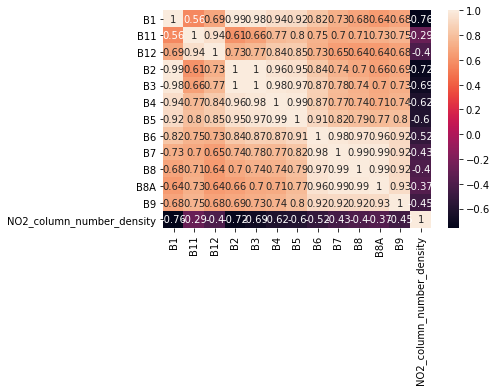

In [218]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

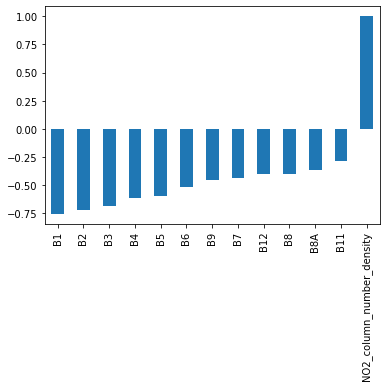

In [219]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [220]:
dtale.show(df)

In [221]:
df.isnull().sum()

B1                           0
B11                          0
B12                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
B8                           0
B8A                          0
B9                           0
NO2_column_number_density    0
dtype: int64

In [222]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [223]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [224]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
# model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/250 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -5.250800298223257e-06

Generation 2 - Current best internal CV score: -5.0739417550534924e-06

Generation 3 - Current best internal CV score: -5.0739417550534924e-06

Generation 4 - Current best internal CV score: -5.071608080513127e-06

Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=5, min_samples_split=14, n_estimators=100)


TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

## Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=5, min_samples_split=14, n_estimators=100)
## TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

In [225]:
#model.export('NO2_Prediction_KR_Toyon_July_September_S2_S5_San_Francisco_tpot_best_model.py')

In [226]:
model = RandomForestRegressor(bootstrap=True, max_features=0.4, min_samples_leaf=5, min_samples_split=14, n_estimators=100)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test)) 

Training Accuracy : 0.870
Test Accuracy : 0.727


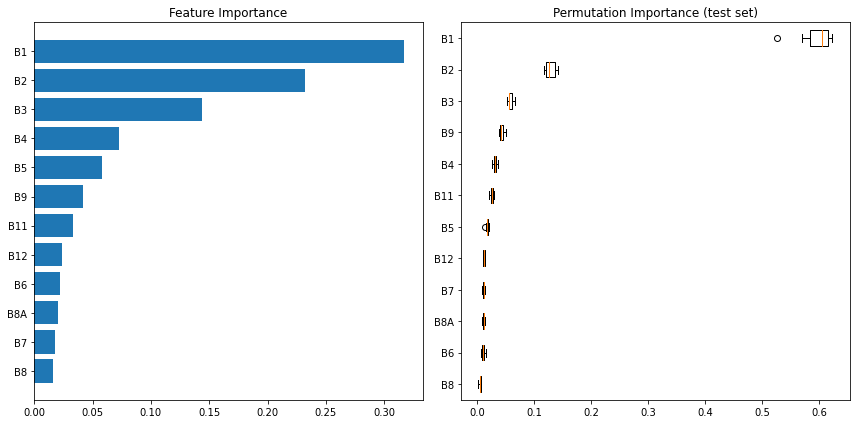

In [227]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 6.133107090903738e-11
Mean absolute percentage error = 0.06360652837353209


Text(0, 0.5, 'NO2_column_number_density')

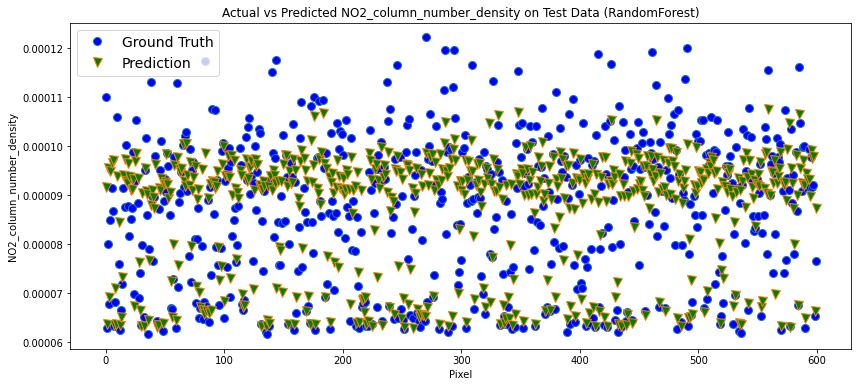

In [228]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 6.986498736270051e-11
Mean absolute percentage error = 0.074129478593825


Text(0, 0.5, 'NO2_column_number_density')

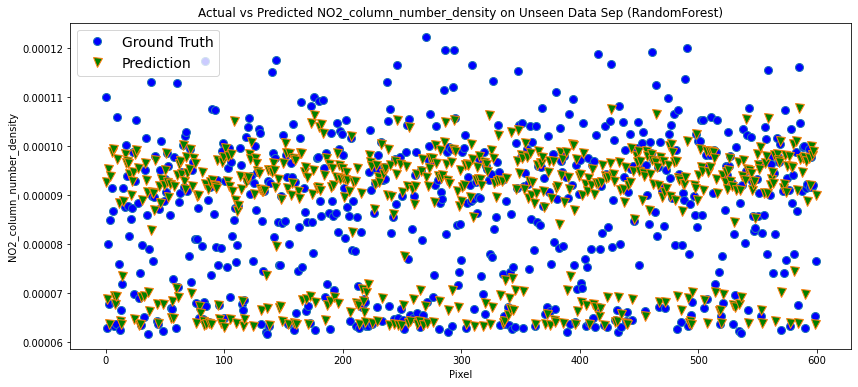

In [229]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Text(0, 0.5, 'NO2_column_number_density')

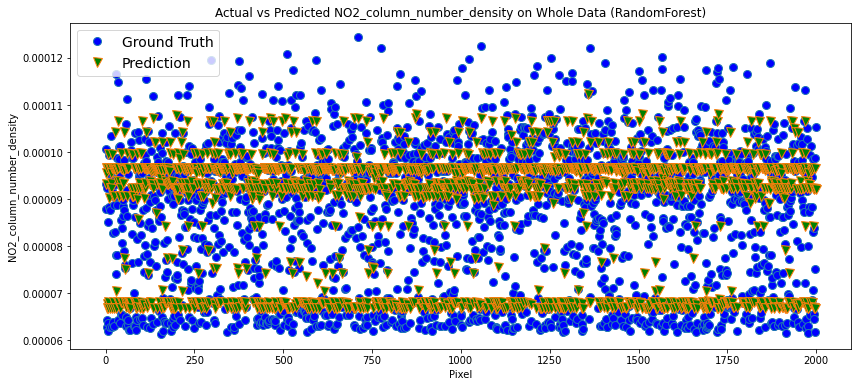

In [230]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [179]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [180]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,-0.177594,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.753354,{'n_estimators': 15}


In [181]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [182]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.776
Test Accuracy : 0.670


Mean Squared Error = 7.39408541914553e-11
Mean absolute percentage error = 0.07511213292917311


Text(0, 0.5, 'NO2_column_number_density')

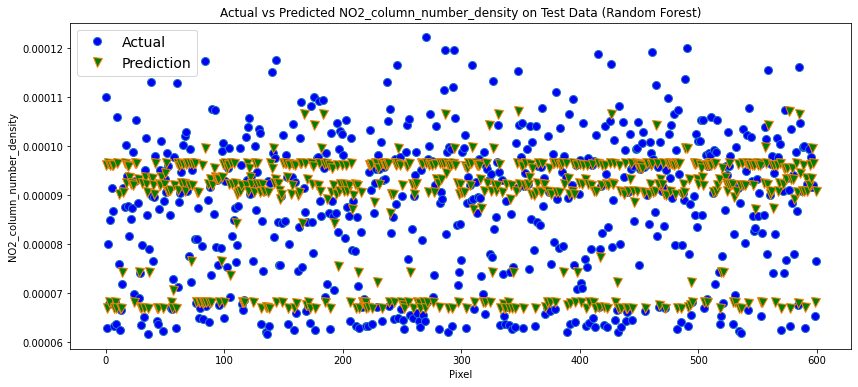

In [183]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 7.422145531995121e-11
Mean absolute percentage error = 0.07601252280035957


Text(0, 0.5, 'NO2_column_number_density')

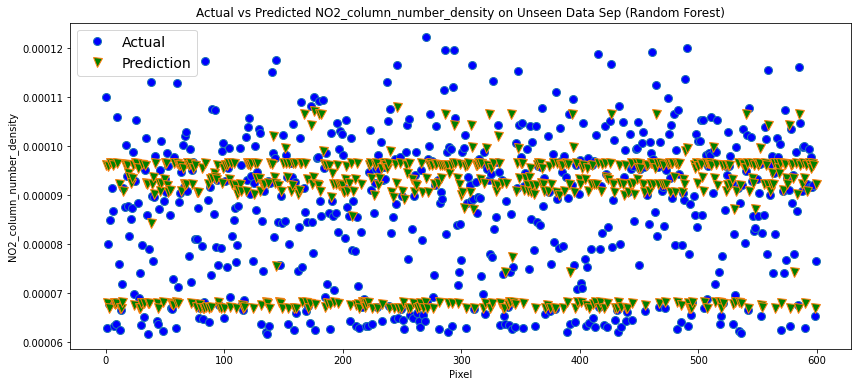

In [184]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [185]:
NO2_column_number_density=df['NO2_column_number_density']

In [186]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

Text(0, 0.5, 'NO2_column_number_density')

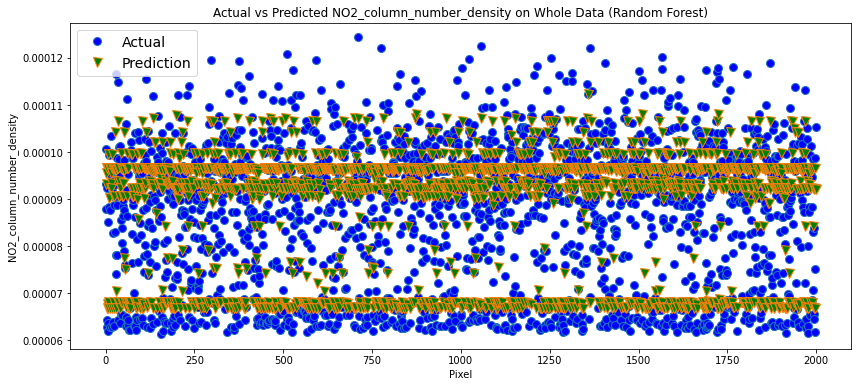

In [187]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [188]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

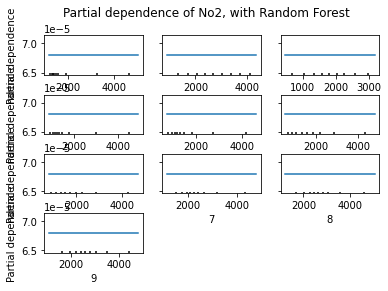

In [189]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [190]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              1187.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:40:39   Log-Likelihood:                          12789.
No. Observations:                1400   AIC:                                 -2.555e+04
Df Residuals:                    1388   BIC:                                 -2.549e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Start Multi-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [191]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")

In [192]:
ground_truth= image_S2_SR.addBands(image_S5P)

In [193]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [194]:
print(points.size().getInfo())

2000


In [195]:
print(points.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.63707972816317, 38.31258651670711]}, 'id': '0', 'properties': {'B1': 1355, 'B11': 2306, 'B12': 1396, 'B2': 1134, 'B3': 1193.5, 'B4': 933.5, 'B5': 1356, 'B6': 2883.5, 'B7': 3306, 'B8': 3094.5, 'B8A': 3489, 'B9': 809.5, 'NO2_column_number_density': 9.315050192526542e-05, 'tropospheric_NO2_column_number_density': 3.5703154719780844e-05}}


In [196]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density,tropospheric_NO2_column_number_density
0,1355.0,2306.0,1396.0,1134.0,1193.5,933.5,1356.0,2883.5,3306.0,3094.5,3489.0,809.5,0.000093,0.000036
1,1162.0,1516.0,888.0,924.0,823.0,748.0,991.0,1561.0,1827.0,1743.0,2010.0,601.0,0.000088,0.000029
2,1445.0,1315.5,1005.5,1106.5,961.0,879.5,996.0,1063.0,1179.0,807.0,1149.5,500.0,0.000101,0.000042
3,1382.0,3739.5,2279.0,1382.5,1481.0,2060.0,2114.0,2466.0,2833.0,2835.5,3295.0,1031.0,0.000092,0.000032
4,4821.5,4091.5,2921.5,4561.0,4237.5,4435.5,4343.5,4448.0,4624.0,4358.5,4707.5,1390.0,0.000063,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4637.0,3827.0,2910.5,4454.0,4092.0,4219.0,4097.5,4156.5,4333.5,4156.5,4410.0,1201.5,0.000065,0.000024
1996,1172.5,2554.0,1831.0,1015.5,991.5,1205.0,1206.5,1534.5,1726.5,1869.5,1912.5,699.5,0.000099,0.000040
1997,5601.0,4970.0,3376.0,5618.0,5286.5,5585.5,5485.5,5562.0,5834.5,5507.5,5918.0,1581.0,0.000062,0.000025
1998,1467.0,3956.5,2613.0,1282.5,1240.0,1557.0,1734.0,1987.5,2298.5,2248.0,2731.0,911.0,0.000075,0.000017


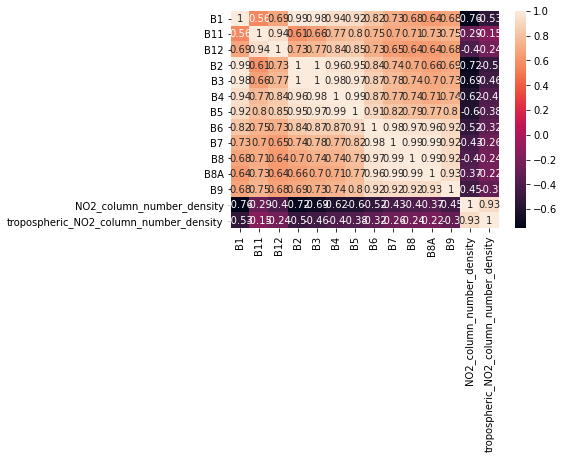

In [197]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

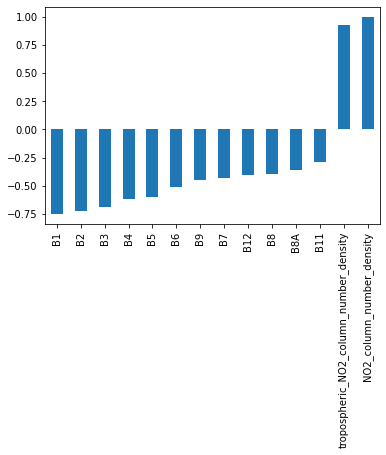

In [198]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [199]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

9.045878559458775e-05
Mean Squared Error = 7.138551126037994e-11
Mean absolute percentage error = 0.07311545702904751
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              1187.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:47:07   Log-Likelihood:                          12789.
No. Observations:                1400   AIC:                                 -2.555e+04
Df Residuals:                    1388   BIC:                                 -2.549e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
  

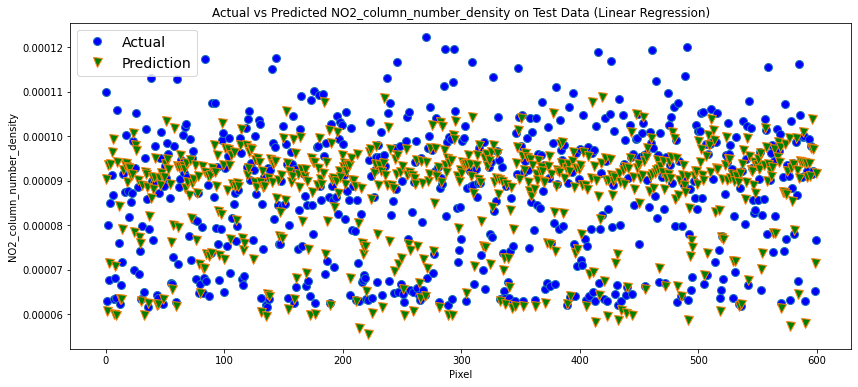

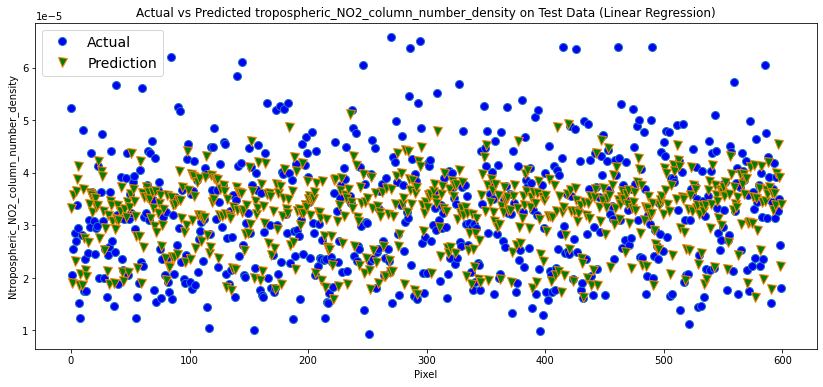

In [201]:
# defining LinearRegression model
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [202]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.581
Test Accuracy : 0.558


# k-Nearest Neighbors for Multioutput Regression

8.717553022186237e-05
Mean Squared Error = 6.41942372764284e-11
Mean absolute percentage error = 0.0623322950880612
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              1187.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:47:08   Log-Likelihood:                          12789.
No. Observations:                1400   AIC:                                 -2.555e+04
Df Residuals:                    1388   BIC:                                 -2.549e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
    

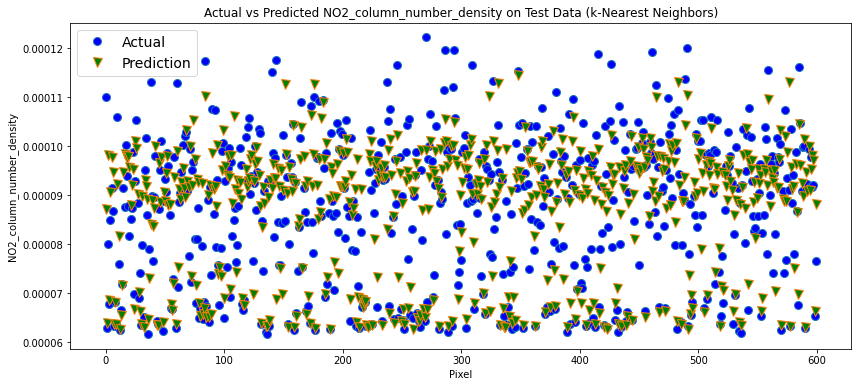

In [203]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [204]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.758
Test Accuracy : 0.589


# Decision Tree for Multioutput Regression

9.553056463752656e-05
Mean Squared Error = 8.001381182348238e-11
Mean absolute percentage error = 0.0715279278988481
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              1187.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:47:08   Log-Likelihood:                          12789.
No. Observations:                1400   AIC:                                 -2.555e+04
Df Residuals:                    1388   BIC:                                 -2.549e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
   

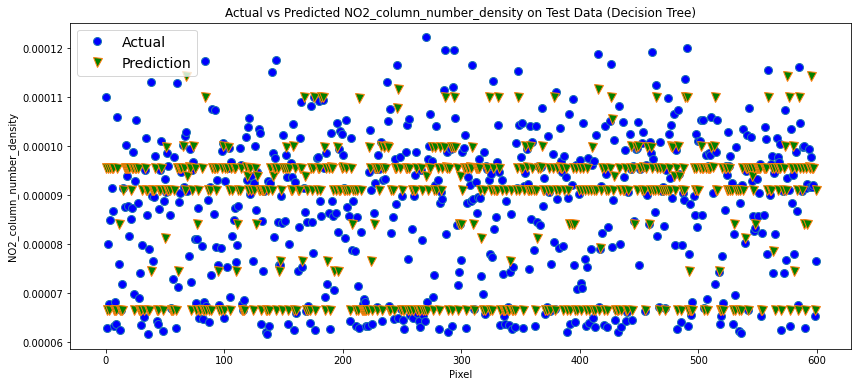

In [205]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [206]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.708
Test Accuracy : 0.528


Mean Squared Error = 6.3896518256114636e-12
Mean absolute percentage error = 0.02029552375019353
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              3761.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:47:10   Log-Likelihood:                          13607.
No. Observations:                1400   AIC:                                 -2.719e+04
Df Residuals:                    1387   BIC:                                 -2.712e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef  

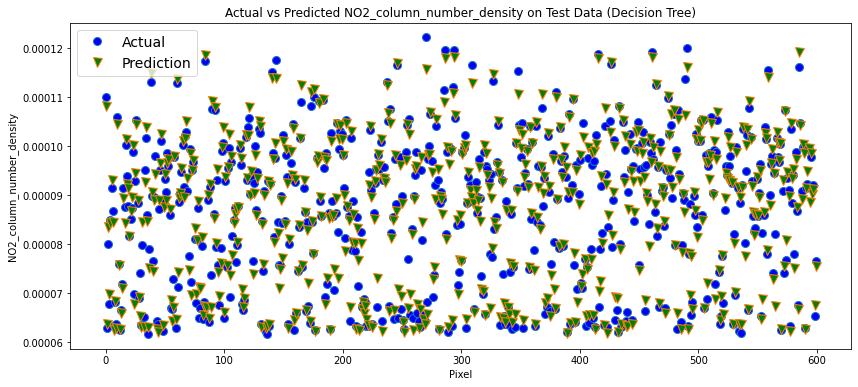

In [207]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))